# Deep Learning $for$ Book Recommending System
This is a project on a Recommendation system that suggest different books to users based on their past behavior i.e., likings and ratings. 
## About the dataset:
The Book-Crossing dataset can be found on the following website:

http://www2.informatik.uni-freiburg.de/~cziegler/BX/

This dataset is a collaborative filtering dataset and contains information about users, books, and ratings. It was collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community, and contains 278,858 users (anonymized) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.

## Load all necessary libraries
This section is about importing all libraries that will make the project walkthrough a success without an error.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

## Load the datasets into this workspace

In [2]:
ratings = pd.read_csv("Data/BX-Book-Ratings.csv", delimiter=";", on_bad_lines='skip')
books = pd.read_csv("Data/BX-Books.csv", delimiter=";", on_bad_lines='skip', low_memory=False)
users = pd.read_csv("Data/BX-Users.csv", delimiter=";", on_bad_lines='skip')

## Data Exploration

### Book Ratings
To get the glimpse of the dataset, I will show the top 3 rows of the book ratings dataset.

In [3]:
ratings.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


* Brief information about different columns of the ratings dataframe:

In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


The `ISBN` (i.e., book-id) is represented as an object. What can causes this is non-numerical character in the ID. Also, from the above information it can be seen that the ratings table has no blank/null values.

In [5]:
ratings.duplicated().any()

False

This confirms that the ratings dataframe has no duplicate values.

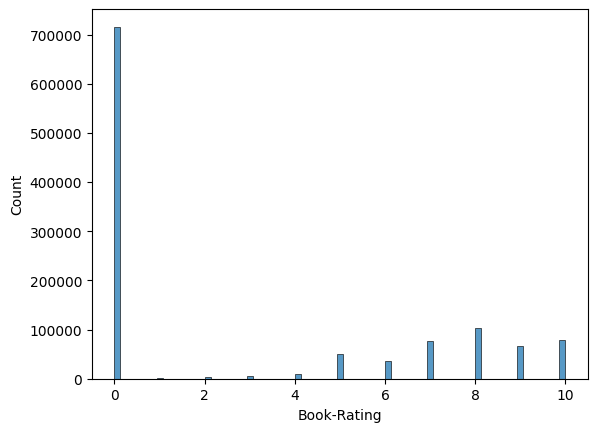

In [6]:
sns.histplot(ratings, x='Book-Rating');

There seem to be more zeros (0) ratings in the book rated. Explicit ratings are what can contribute to the effectiveness of the model to be built, these zeros will serve as redundancy to the model.

### Book information
* Top 3 rows of the books information:

In [7]:
books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


* Brief information about different columns of the books dataframe:

In [8]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271361 entries, 0 to 271360
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271361 non-null  object
 1   Book-Title           271361 non-null  object
 2   Book-Author          271360 non-null  object
 3   Year-Of-Publication  271361 non-null  object
 4   Publisher            271359 non-null  object
 5   Image-URL-S          271361 non-null  object
 6   Image-URL-M          271361 non-null  object
 7   Image-URL-L          271358 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


The same is true for this dataset also i.e., `ISBN` column is represented as an object instead of an integer. One book author and two publisers are missing in the dataset.

In [9]:
books.isna().any()

ISBN                   False
Book-Title             False
Book-Author             True
Year-Of-Publication    False
Publisher               True
Image-URL-S            False
Image-URL-M            False
Image-URL-L             True
dtype: bool

In the books table, three columns contain missing data i.e., `Book-Author`, `Publiser` and `Image-URL-L`.

In [10]:
books.duplicated().any()

False

The books table has no duplicate values.

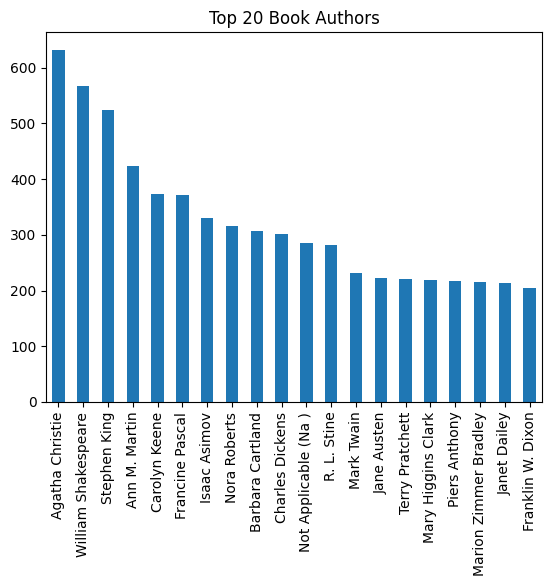

In [11]:
books["Book-Author"].value_counts()[:20].plot.bar()
plt.title("Top 20 Book Authors");

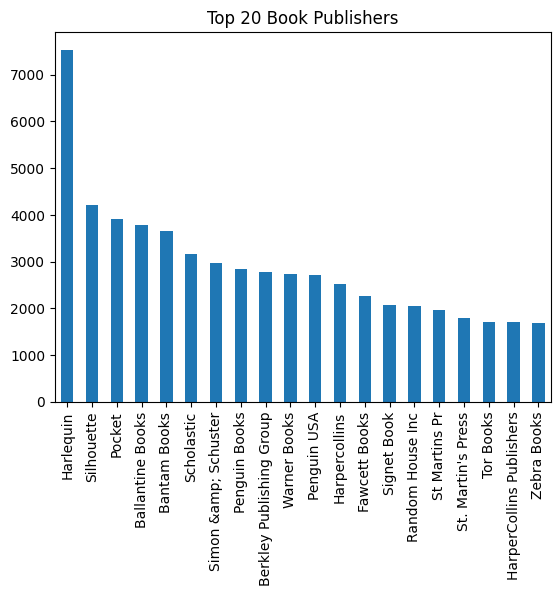

In [12]:
books["Publisher"].value_counts()[:20].plot.bar()
plt.title("Top 20 Book Publishers");

### Users information
* Top 5 header lines of the users information

In [13]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Three attributes are in a column i.e., Location ["City", "State", "Country"]

* Brief information about different columns of the users dataframe:

In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


The age column seems to have many missing values.

In [15]:
users[users["Age"].isna()].head(10)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
2,3,"moscow, yukon territory, russia",NaN
4,5,"farnborough, hants, united kingdom",NaN
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
11,12,"fort bragg, california, usa",NaN
13,14,"mediapolis, iowa, usa",NaN
14,15,"calgary, alberta, canada",NaN
15,16,"albuquerque, new mexico, usa",NaN


In [16]:
users["Age"].describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

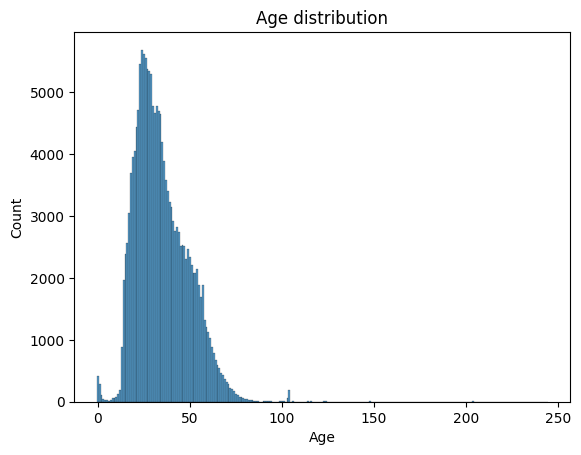

In [17]:
# Distribution of the age of users

sns.histplot(users, x="Age", discrete=True)
plt.title("Age distribution");

There seem to be some few outliers in the age distribution.

In [18]:
# Checking for duplicate
users.duplicated().any()

False

No duplicate entry is detected.

### GENERAL OBSERVATIONS:
- The three datasets have no duplicate entry, but some null entries were detected.
- The "books" dataframe contains some unnecessary columns which are not needed for this analysis e.g. `"Image-URL-S"`, `"Image-URL-M"`, `"Image-URL-L"` etc.
- Two books have no Publishers and one book has no Author which will not be needed for the analysis.
- Some wrong columns are assigned to the `"Year-Of-Publication"` in the `books` dataframe which makes it to be loaded as an `object` instead of an `integer`.
- `ISBN` column (i.e., the book-id) has been misrepresented due to some non numerical characters.
- The location column in the users dataset has three attributes (i.e., City, State and Country), placing these attributes in their right column will improve the data quality.
- The users age seems to have many outliers (i.e., values above 110), using imputation techniques to handle this will bring about consistency.
- Since we will be working with explicit ratings, ratings with the value of zero(0) will not be needed for the recommendation system to avoid redundancy.



## Data Cleaning
In this section, I will remove all the unnecessary columns and the invalid rows from the dataframe. Some user-id and book-id have unknown character which make them to be represented as an object. So, I will be using the LabelEncoder() function of the sklearn library to encode each and every id in the dataset to a numerical equivalent. But before that, I will remove all unknown ids in both User-ID and ISBN in the ratings dataframe.

* Drop all redundant columns from the books dataframe:

In [19]:
# Drop unnecessary columns
books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True)

- Remove all missing values in the books table

In [20]:
books.dropna(inplace=True)

- Remove all zero ratings from the book dataset

In [21]:
ratings = ratings[ratings["Book-Rating"]!=0]

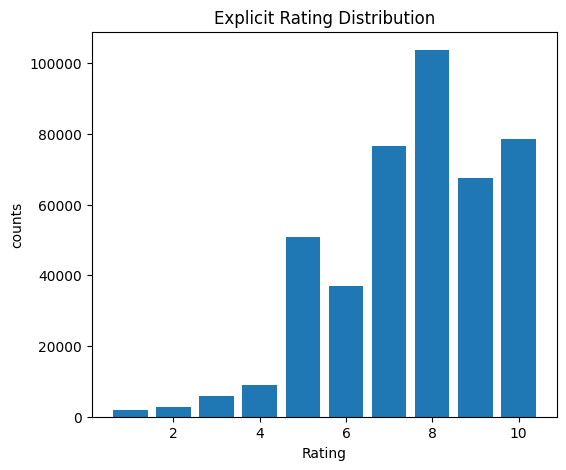

In [22]:
rtg = ratings["Book-Rating"].value_counts().sort_index()

plt.figure(figsize=(6, 5))
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.title('Explicit Rating Distribution');

- Expand the Location column in the user's table to improve the data quality

In [23]:
users[["City", "State", "Country"]] = users["Location"].str.split(", ", n=2, expand=True)

users.loc[(users["State"]=='\\n/a\\"') | (users["State"]=='') | (users["State"]=='*') | 
          (users["State"]=='n.a'), ['State']] = 'n/a'
users["State"].fillna('other', inplace=True)
users[["City", "State", "Country"]] = users.loc[:, ["City", "State", "Country"]
                                                ].apply(lambda cols: cols.str.title()).fillna('n/a')
users.drop("Location", axis=1, inplace=True)

users.head()

,User-ID,Age,City,State,Country
0,1,NaN,Nyc,New York,Usa
1,2,18.0,Stockton,California,Usa
2,3,NaN,Moscow,Yukon Territory,Russia
3,4,17.0,Porto,V.N.Gaia,Portugal
4,5,NaN,Farnborough,Hants,United Kingdom


- Handle all outliers in the age column

In [24]:
# Imputation techniques will be used to handle these
users.loc[users['Age'] > 110, "Age"] = np.nan
users.loc[users['Age'] < 5, "Age"] = np.nan 

- Perform imputation on the missing age

In [25]:
temp_age_series = pd.Series(np.random.normal(loc=users["Age"].mean(), scale=users["Age"].std(),
                                              size=users["Age"].isna().values.sum())).abs()

In [26]:
# Sort users table using age, make sure that missing values come first so as to replace them directly
users = users.sort_values('Age',na_position='first').reset_index(drop=True)
users["Age"].fillna(temp_age_series, inplace=True)
users.loc[users['Age'] < 5, "Age"] = users['Age'].mean()
users["Age"] = users["Age"].astype(int)

In [27]:
users.head()

,User-ID,Age,City,State,Country
0,1,28,Nyc,New York,Usa
1,3,34,Moscow,Yukon Territory,Russia
2,5,32,Farnborough,Hants,United Kingdom
3,7,36,Washington,Dc,Usa
4,8,24,Timmins,Ontario,Canada


In [28]:
users["Age"].describe()

count    278858.000000
mean         34.864067
std          13.642909
min           5.000000
25%          25.000000
50%          33.000000
75%          44.000000
max         110.000000
Name: Age, dtype: float64

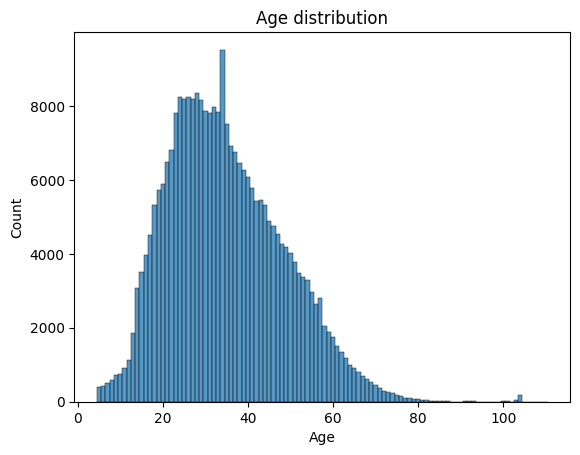

In [29]:
# Distribution of the age of users after outlier handliing

sns.histplot(users, x="Age", discrete=True)
plt.title("Age distribution");

In [30]:
users.head()

,User-ID,Age,City,State,Country
0,1,28,Nyc,New York,Usa
1,3,34,Moscow,Yukon Territory,Russia
2,5,32,Farnborough,Hants,United Kingdom
3,7,36,Washington,Dc,Usa
4,8,24,Timmins,Ontario,Canada


* Remove rows with id that are not in the books and users dataframe:

In [31]:
ratings = ratings[ratings['ISBN'].isin(books['ISBN'].values)]
ratings = ratings[ratings['User-ID'].isin(users['User-ID'].values)]

* Transform all IDs to integer equivalent using LabelEncoder

In [32]:
# Transform both the user and the book IDs
isbn_transformer = LabelEncoder().fit(books['ISBN'])
books['ISBN'] = isbn_transformer.transform(books['ISBN'])
ratings['ISBN'] = isbn_transformer.transform(ratings['ISBN'])

userid_transformer = LabelEncoder().fit(users['User-ID'])
users['User-ID'] = userid_transformer.transform(users['User-ID'])
ratings['User-ID'] = userid_transformer.transform(ratings['User-ID'])

## Brief overview of dataframes after data cleaning

#### Ratings

In [33]:
ratings.head()

,User-ID,ISBN,Book-Rating
1,276725,22827,5
3,276728,111840,3
4,276728,111874,6
8,276743,70983,7
16,276746,5734,9


In [34]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383841 entries, 1 to 1149778
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   User-ID      383841 non-null  int64
 1   ISBN         383841 non-null  int32
 2   Book-Rating  383841 non-null  int64
dtypes: int32(1), int64(2)
memory usage: 10.2 MB


#### Books

In [35]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,25028,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,73,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,8211,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,60198,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,71711,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [36]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271358 entries, 0 to 271360
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271358 non-null  int32 
 1   Book-Title           271358 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271358 non-null  object
 4   Publisher            271358 non-null  object
dtypes: int32(1), object(4)
memory usage: 11.4+ MB


#### Users

In [37]:
users.head()

,User-ID,Age,City,State,Country
0,0,28,Nyc,New York,Usa
1,2,34,Moscow,Yukon Territory,Russia
2,4,32,Farnborough,Hants,United Kingdom
3,6,36,Washington,Dc,Usa
4,7,24,Timmins,Ontario,Canada


In [38]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int32 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int32(1), int64(1), object(3)
memory usage: 9.6+ MB


## Building Recommendation System
In this section, I will be building a recommendation system. But before then, I will create a traininig and testing set to test the performance of my model. The library that can help in the splitting of the dataset into training and testing set is `train_test_split()` function of sklearn library.

In [39]:
from model import RecommendationSystem

In [40]:
rmodel = RecommendationSystem(ratings=ratings,
                              books=books,
                              users=users)

In [41]:
rmodel.build_fit_model()

Epoch 1/10
10556/10556 [==============================] - 928s 88ms/step - loss: 61.4510 - val_loss: 60.4877
Epoch 2/10
10556/10556 [==============================] - 924s 87ms/step - loss: 56.2868 - val_loss: 53.0246
Epoch 3/10
10556/10556 [==============================] - 874s 83ms/step - loss: 45.5371 - val_loss: 46.0383
Epoch 4/10
10556/10556 [==============================] - 5424s 514ms/step - loss: 36.5521 - val_loss: 41.3468
Epoch 5/10
10556/10556 [==============================] - 1054s 100ms/step - loss: 29.5829 - val_loss: 38.1337
Epoch 6/10
10556/10556 [==============================] - 1549s 147ms/step - loss: 24.1338 - val_loss: 35.9600
Epoch 7/10
10556/10556 [==============================] - 1247s 118ms/step - loss: 19.8828 - val_loss: 34.4606
Epoch 8/10
10556/10556 [==============================] - 1279s 121ms/step - loss: 16.5404 - val_loss: 33.3882
Epoch 9/10
10556/10556 [==============================] - 1101s 104ms/step - loss: 13.8890 - val_loss: 32.6280
Epoch 1

#### Recommend books to a user [`276821`]
> * These are the books the interested user (i.e., `276821`) has read:

In [48]:
books.loc[books['ISBN'].isin(ratings.loc[ratings['User-ID']==276821, "ISBN"])]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
1027,62977,Hoot (Newbery Honor Book),CARL HIAASEN,2002,Knopf Books for Young Readers
15602,169901,"Artemis Fowl (Artemis Fowl, Book 1)",Eoin Colfer,2002,Miramax Kids
17084,3504,The Boy Next Door,Meggin Cabot,2002,Avon Trade
27516,65338,A Kid's Guide to How to Save the Planet (Camel...,Billy Goodman,1990,Harpercollins Juvenile Books
34236,21203,Skin and Other Stories (Now in Speak!),Roald Dahl,2002,Puffin Books
50710,176320,The Number Devil: A Mathematical Adventure,Hans Magnus Enzensberger,1998,Henry Holt &amp; Company
80669,151553,A String in the Harp,Nancy Bond,1996,Aladdin
88354,169814,The Sandy Bottom Orchestra,Jenny Nilson,1998,Hyperion Books for Children
115319,84836,The Contest,Gordon Korman,2002,Scholastic
140332,231140,Random Acts of Kindness,Dawna Markova,2002,Conari Press


* These are the books recommended to the user:

In [49]:
rmodel.recommend_books(276821)

Recommended book 1: 'Seta' <====> Score: 18.21733856201172
Recommended book 2: 'Il Piccolo Principe Prince Italn' <====> Score: 17.39213752746582
Recommended book 3: "The Razor's Edge (Penguin Twentieth-Century Classics)" <====> Score: 16.505367279052734
Recommended book 4: 'The Nanny Diaries: A Novel' <====> Score: 16.434738159179688
Recommended book 5: 'Son De Mar' <====> Score: 16.265371322631836
Recommended book 6: 'A Prayer for Owen Meany' <====> Score: 15.911930084228516
Recommended book 7: "The Bonesetter's Daughter" <====> Score: 15.547650337219238
Recommended book 8: 'The SECRET BOOK OF GRAZIA DEI ROSSI' <====> Score: 15.20815658569336
Recommended book 9: 'Summer Sisters' <====> Score: 15.160934448242188
Recommended book 10: 'Prodigal Summer: A Novel' <====> Score: 15.15168571472168


More details about the different recommended books:

In [50]:
rmodel.recommended_books_table()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
541,33527,The Nanny Diaries: A Novel,Emma McLaughlin,2002,St. Martin's Press
1387,43951,A Prayer for Owen Meany,John Irving,1990,Ballantine Books
1680,87388,Summer Sisters,Judy Blume,1999,Dell Publishing Company
5065,7912,Prodigal Summer: A Novel,Barbara Kingsolver,2001,Perennial
5105,268815,Son De Mar,Manuel Vicent,2002,Suma de Letras
5253,269392,Seta,Alessandro Baricco,0,Rizzoli - RCS Libri
5977,175248,The Bonesetter's Daughter,Amy Tan,2002,Ballantine Books
6413,148343,The SECRET BOOK OF GRAZIA DEI ROSSI,Jacqueline Park,1998,Simon &amp; Schuster
12620,269561,Il Piccolo Principe Prince Italn,Antoine de Saint-Exupéry,0,Bompiani Italian
27588,17233,The Razor's Edge (Penguin Twentieth-Century Cl...,W. Somerset Maugham,1992,Penguin Books


#### Recommend books to a user [`103`]
> * These are the books the interested user (i.e., `103`) has read:

In [51]:
books.loc[books['ISBN'].isin(ratings.loc[ratings['User-ID']==242, "ISBN"])]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
202,8384,The God of Small Things,Arundhati Roy,1998,Perennial
210,60910,Memoirs of a Geisha,Arthur Golden,1997,Alfred A. Knopf
217,69454,Legacy of Silence,Belva Plain,1998,Bantam Dell Pub Group
227,95511,Manhattan Hunt Club,JOHN SAUL,2002,Ballantine Books
233,122142,The Patient,Michael Palmer,2001,Bantam Books
240,170267,A Monk Swimming,Malachy McCourt,1998,Hyperion
241,174361,Crazy Horse,Mari Sandoz,1961,University of Nebraska Press
244,222520,Chicken Soup for the Soul (Chicken Soup for th...,Jack Canfield,1993,Health Communications
305,87704,A Painted House,John Grisham,2001,Dell Publishing Company
516,7063,The Bean Trees,Barbara Kingsolver,1989,Perennial


* These are the books recommended to the user:

In [52]:
rmodel.recommend_books(242)

Recommended book 1: 'Jade Peony' <====> Score: 13.0747652053833
Recommended book 2: 'Angels' <====> Score: 12.044463157653809
Recommended book 3: 'Almost blue (Stile libero)' <====> Score: 12.008554458618164
Recommended book 4: 'She Said Yes : The Unlikely Martyrdom of Cassie Bernall' <====> Score: 11.720483779907227
Recommended book 5: 'Eine Frau, Eine Wohnung, Ein Roman' <====> Score: 11.709243774414062
Recommended book 6: 'Io Non Ho Paura' <====> Score: 11.69848918914795
Recommended book 7: 'L.A. Dead: A Stone Barrington Novel (Stone Barrington Novels (Paperback))' <====> Score: 10.739686012268066
Recommended book 8: 'Happy Are the Peace Makers' <====> Score: 10.590791702270508
Recommended book 9: 'Native Tongue' <====> Score: 10.561357498168945
Recommended book 10: 'Das Echo.' <====> Score: 10.528139114379883


More details about the different recommended books:

In [53]:
rmodel.recommended_books_table()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
3209,269209,Almost blue (Stile libero),Carlo Lucarelli,1997,Einaudi
5601,158257,She Said Yes : The Unlikely Martyrdom of Cassi...,Misty Bernall,2000,Pocket
6816,97046,Native Tongue,Carl Hiaasen,1992,Fawcett Books
7159,3236,Angels,Marian Keyes,2002,William Morrow
8753,269204,Io Non Ho Paura,Niccolo Ammaniti,2002,Distribooks Inc
11622,218379,Jade Peony,Wayson Choy,1995,Harpercollins Canada
26913,100935,L.A. Dead: A Stone Barrington Novel (Stone Bar...,Stuart Woods,2001,Signet Book
33734,256317,Das Echo.,Minette Walters,1999,Goldmann
45464,108428,Happy Are the Peace Makers,Andrew M. Greeley,1993,Jove Books
51797,257045,"Eine Frau, Eine Wohnung, Ein Roman",Wilhelm Genazino,2003,Hanser Gardner Publications
